In [2]:
import pandas as pd
import numpy as np

In [17]:
# write lat longs to csv
voterlatlong = pd.read_csv('voter_address_lat_long.csv', sep='\t')

/Users/leey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
voterlatlong.head()
# voterlatlong[voterlatlong.VOTER_ID==300427492]

,VOTER_ID,dates,addresses,Lat,Long
0,519109,2006-05-16,NaN,NaN,NaN
1,519109,2006-09-19,NaN,NaN,NaN
2,519109,2006-11-07,NaN,NaN,NaN
3,519109,2007-05-15,NaN,NaN,NaN
4,519109,2007-11-06,NaN,NaN,NaN


In [19]:
# drop dates, no longer needed, since we are only looking where they moved to, actually don't need year either
voterlatlong['moveyear'] = pd.to_numeric(voterlatlong.dates.apply(lambda x: x.split('-')[0]), downcast='integer')
voterlatlong = voterlatlong.drop(['dates'], axis=1)

In [20]:
voterlatlong.head()

,VOTER_ID,addresses,Lat,Long,moveyear
0,519109,NaN,NaN,NaN,2006
1,519109,NaN,NaN,NaN,2006
2,519109,NaN,NaN,NaN,2006
3,519109,NaN,NaN,NaN,2007
4,519109,NaN,NaN,NaN,2007


In [21]:
# keep only the first time a new address appears
voterlatlong = voterlatlong.drop_duplicates(subset=['VOTER_ID', 'addresses'],keep='first')

In [22]:
# force to numeric
voterlatlong['Lat'] = pd.to_numeric(voterlatlong['Lat'], downcast='float', errors='coerce')
voterlatlong['Long'] = pd.to_numeric(voterlatlong['Long'], downcast='float', errors='coerce')

In [23]:
# drop all nan rows
voterlatlong = voterlatlong.dropna(how='any')

In [24]:
# need to get age
voterages = pd.read_csv('voter_info.csv', sep='\t')
voterages.head()

,VOTER_ID,FIRST_NAME,MIDDLE_NAME,LAST_NAME,BIRTH_DATE,PARTY_CODE,year,age2018,age2016,age2006,counts
0,519109,DANE,WILLARD,WAHLSTROM,07-20-1979,DEM,1979,39.0,37.0,27.0,3
1,100064977,JAMES,EUGENE,MORTENSEN,08-07-1977,REP,1977,41.0,39.0,29.0,1
2,100042592,JARED,BANKES,HERZOG,07-25-1978,DEM,1978,40.0,38.0,28.0,4
3,11573337,JOE,H,FERGUSON,10-11-1951,PGP,1951,67.0,65.0,55.0,1
4,300469994,KAY'RIONNA,DANAE,WATSON,03-25-1998,NAV,1998,20.0,18.0,8.0,1


In [25]:
voterages = voterages[['VOTER_ID', 'year']]

In [26]:
voterlatlong = voterlatlong.join(voterages.set_index('VOTER_ID'), on='VOTER_ID')
voterlatlong.head()

,VOTER_ID,addresses,Lat,Long,moveyear,year
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0
25,100064977,7307 SE 70TH AVE PORTLAND OR 97206,45.470184,-122.591377,2006,1977.0
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0


In [27]:
# filter out the voters with less than 1 row
voterlatlong = voterlatlong[voterlatlong.duplicated(subset=['VOTER_ID'], keep=False)]

In [28]:
#!/usr/bin/env python

# Haversine formula example in Python
# Author: Wayne Dyck

import math

def f(x):
    return math.atan2(x[0], x[1])

def distance(lat1, lon1, destination):
#     lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = (lat2-lat1).apply(math.radians)
    dlon = (lon2-lon1).apply(math.radians)
    tlat1 = lat1.apply(math.radians)
    a = (dlat/2).apply(math.sin) * (dlat/2).apply(math.sin) + tlat1.apply(math.cos) \
        * math.cos(math.radians(lat2)) * (dlon/2).apply(math.sin) * (dlon/2).apply(math.sin)

    df = pd.DataFrame({'a':a.apply(math.sqrt), 'b':(1-a).apply(math.sqrt)})
    c = 2 * df.apply(f, axis=1)
    d = radius * c
    # convert to miles: 1 km = 0.621371 miles
    d = d*0.621371

    return d

In [14]:
# find distance from center (burnside bridge)
center = [45.523049 , -122.667385]

# calculate distance (miles) from center for each person
voterlatlong['distcenter'] = distance(voterlatlong['Lat'], voterlatlong['Long'], center)

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677


In [35]:
voterlatlong[voterlatlong['distcenter']<0.1].addresses

5072288    UNDER WEST SIDE OF BURNSIDE BRIDGE PORTLAND OR...
Name: addresses, dtype: object

In [ ]:
# throw out less than 0.1 miles (applied to the wrong column)
voterlatlong['distcenter'].min()
voterlatlong = voterlatlong[voterlatlong['distcenter']>0.1]
voterlatlong.head()

In [25]:
# need the following:
# column for the displacement from previous address
# column for the angle from the previous to new address
# column for x coord based on previous address (trying to answer whether peopple are moving away or towards center)
# column for y coord based on previous address (trying to answer whether peopple are moving away or towards center)
# column for age at the time of move

# this is correct, there are in fact some individuals with ages below 18 at the time of relocation
voterlatlong['relocationage'] = voterlatlong.moveyear - voterlatlong.year
# voterlatlong[voterlatlong.relocationage<18]

[45.523049, -122.667385]

In [16]:
voterlatlong.head()

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter,relocationage
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245,29.0
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963,31.0
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089,33.0
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0


In [27]:
# center all addresses to the city center (burnside bridge)
voterlatlong['cLat'] = voterlatlong.Lat - center[0]
voterlatlong['cLong'] = voterlatlong.Long - center[1]
voterlatlong.head()

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter,relocationage,cLat,cLong
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245,29.0,-0.008248,0.040165
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963,31.0,0.013160,0.067127
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089,33.0,0.014503,0.040768
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0,0.002464,-0.028370
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0,-0.011651,-0.012417


In [46]:
# df has age at move, dist away or toward center, and angle
df = pd.DataFrame()
voters = voterlatlong.VOTER_ID.unique()
voters

array([   519109, 100042592,  11909656, ...,  11448957, 100131085,
       200000909])

In [18]:
from ipywidgets import FloatProgress
from IPython.display import display

In [47]:
temp = voterlatlong[voterlatlong.VOTER_ID==voters[1]]
temp.sort_values(by='moveyear', ascending=True)

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter,relocationage,cLat,cLong
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0,0.002464,-0.028370
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0,-0.011651,-0.012417
61,100042592,1527 SW 18TH AVE PORTLAND OR 97201,45.516491,-122.693466,2013,1978.0,1.341464,35.0,-0.006558,-0.026081
67,100042592,411 NW FLANDERS ST APT 306 PORTLAND OR 97209,45.526051,-122.674637,2016,1978.0,0.407724,38.0,0.003002,-0.007252


In [48]:
max_count = len(voters)

fb = FloatProgress(min=0, max=max_count) # instantiate the bar
display(fb) # display the bar

# for each voter, shove into the above df
for voter in voters:
    # signal to increment the progress bar
    fb.value += 1
    
    # pull out individuals
    temp = voterlatlong[voterlatlong.VOTER_ID == voter]
    temp2 = temp.copy()
    # sort by move year (oldest to newest)
    temp = temp.sort_values(by='moveyear', ascending=True)
    # calculate the distance and angle between the previous and the next address
    temp2['consecdist'] = temp.distcenter.diff()
    temp2['radians'] = np.arctan2(temp['cLat'], temp['cLong'])
    df = df.append(temp2)

In [49]:
df.head()

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter,relocationage,cLat,cLong,consecdist,radians
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245,29.0,-0.008248,0.040165,NaN,-0.202537
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963,31.0,0.013160,0.067127,1.347719,0.193592
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089,33.0,0.014503,0.040768,-1.160875,0.341784
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0,0.002464,-0.028370,NaN,3.054968
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0,-0.011651,-0.012417,-0.379147,-2.388021


In [62]:
# need x and y coordinates from consecdist and radians
df['x'] = df.consecdist*np.cos(df.radians)
df['y'] = df.consecdist*np.sin(df.radians)

In [63]:
df.head()

,VOTER_ID,addresses,Lat,Long,moveyear,year,distcenter,relocationage,cLat,cLong,consecdist,radians,x,y
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245,29.0,-0.008248,0.040165,NaN,-0.202537,NaN,NaN
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963,31.0,0.013160,0.067127,1.347719,0.193592,1.322543,0.259281
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089,33.0,0.014503,0.040768,-1.160875,0.341784,-1.093727,-0.389089
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0,0.002464,-0.028370,NaN,3.054968,NaN,NaN
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0,-0.011651,-0.012417,-0.379147,-2.388021,0.276493,0.259430


In [66]:
df = df.rename(columns={'year':'birthyear'})

In [67]:
# dump into csv, took way too long to get this
df.to_csv('move_dist_angle_df.csv', sep='\t')

In [71]:
df.head()

,VOTER_ID,addresses,Lat,Long,moveyear,birthyear,distcenter,relocationage,cLat,cLong,consecdist,radians,x,y
5,519109,3542 SE TAYLOR ST PORTLAND OR 97214,45.514801,-122.627220,2008,1979.0,2.026245,29.0,-0.008248,0.040165,NaN,-0.202537,NaN,NaN
8,519109,1834 NE 61ST AVE PORTLAND OR 97213,45.536209,-122.600258,2010,1979.0,3.373963,31.0,0.013160,0.067127,1.347719,0.193592,1.322543,0.259281
13,519109,3568 NE US GRANT PL PORTLAND OR 97212,45.537552,-122.626617,2012,1979.0,2.213089,33.0,0.014503,0.040768,-1.160875,0.341784,-1.093727,-0.389089
48,100042592,2170 NW FLANDERS ST PORTLAND OR 97210,45.525513,-122.695755,2006,1978.0,1.383823,28.0,0.002464,-0.028370,NaN,3.054968,NaN,NaN
54,100042592,1720 SW 4TH AVE APT 101 PORTLAND OR 97201,45.511398,-122.679802,2010,1978.0,1.004677,32.0,-0.011651,-0.012417,-0.379147,-2.388021,0.276493,0.259430


In [73]:
df2 = df[['relocationage', 'consecdist', 'x', 'y', 'cLat', 'cLong', 'moveyear', 'radians']]
df2.head()

,relocationage,consecdist,x,y,cLat,cLong,moveyear,radians
5,29.0,NaN,NaN,NaN,-0.008248,0.040165,2008,-0.202537
8,31.0,1.347719,1.322543,0.259281,0.013160,0.067127,2010,0.193592
13,33.0,-1.160875,-1.093727,-0.389089,0.014503,0.040768,2012,0.341784
48,28.0,NaN,NaN,NaN,0.002464,-0.028370,2006,3.054968
54,32.0,-0.379147,0.276493,0.259430,-0.011651,-0.012417,2010,-2.388021


In [74]:
df2 = df2.dropna()
df2.head()

,relocationage,consecdist,x,y,cLat,cLong,moveyear,radians
8,31.0,1.347719,1.322543,0.259281,0.013160,0.067127,2010,0.193592
13,33.0,-1.160875,-1.093727,-0.389089,0.014503,0.040768,2012,0.341784
54,32.0,-0.379147,0.276493,0.259430,-0.011651,-0.012417,2010,-2.388021
61,35.0,0.336787,-0.326620,-0.082128,-0.006558,-0.026081,2013,-2.895252
67,38.0,-0.933740,0.862757,-0.357099,0.003002,-0.007252,2016,2.749158


In [80]:
df2['degrees'] = np.mod((df2.radians + 2*np.pi)*180/np.pi, 360)

In [82]:
df2 = df2.drop('radians', axis=1)

In [83]:
df2.head()

,relocationage,consecdist,x,y,cLat,cLong,moveyear,degrees
8,31.0,1.347719,1.322543,0.259281,0.013160,0.067127,2010,11.092017
13,33.0,-1.160875,-1.093727,-0.389089,0.014503,0.040768,2012,19.582788
54,32.0,-0.379147,0.276493,0.259430,-0.011651,-0.012417,2010,223.176454
61,35.0,0.336787,-0.326620,-0.082128,-0.006558,-0.026081,2013,194.114304
67,38.0,-0.933740,0.862757,-0.357099,0.003002,-0.007252,2016,157.515129


In [136]:
# dump into csv, took way too long to get this
df2.to_csv('subset_move_dist_angle_df.csv', sep='\t', index=False)

In [3]:
df2 = pd.read_csv('subset_move_dist_angle_df.csv', sep='\t')

In [125]:
mask = abs(df2.consecdist)<0.1
df2 = df2[~mask]

In [4]:
import matplotlib.pyplot as plt

In [113]:
df = df2.copy()
df = df.dropna(how='any')
age_groups = [18, 26, 33, 40, 50, 150];
# group by age
df['age_group'] = 0
for i in range(0, len(age_groups) - 1):
    # assign age group category for edf.currageon
    df.loc[(df.relocationage>=age_groups[i]) & (df.relocationage<age_groups[i+1]), 'age_group'] = age_groups[i]

In [5]:
df2.head()

,relocationage,consecdist,x,y,cLat,cLong,moveyear,degrees,age_group
0,31.0,1.347719,1.322543,0.259281,0.013160,0.067127,2010,11.092017,26
1,33.0,-1.160875,-1.093727,-0.389089,0.014503,0.040768,2012,19.582788,33
2,32.0,-0.379147,0.276493,0.259430,-0.011651,-0.012417,2010,223.176454,26
3,35.0,0.336787,-0.326620,-0.082128,-0.006558,-0.026081,2013,194.114304,33
4,38.0,-0.933740,0.862757,-0.357099,0.003002,-0.007252,2016,157.515129,33


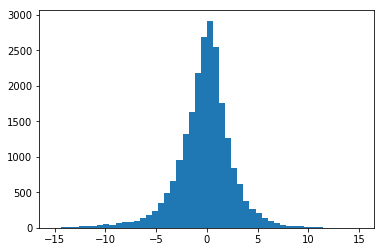

negative: 0.5032391697148649
positive: 0.49676083028513507
count    22691.000000
mean        -0.208136
std          2.799346
min        -34.650740
25%         -1.491958
50%         -0.112178
75%          1.243965
max         23.449708
Name: consecdist, dtype: float64


In [160]:
temp = df2.loc[df2.age_group==18,'consecdist']
plt.hist(temp, bins=50, range=[-15, 15])
plt.show()
print('negative: {}'.format(sum(temp<0)/temp.shape[0]))
print('positive: {}'.format(sum(temp>0)/temp.shape[0]))
print(temp.describe())

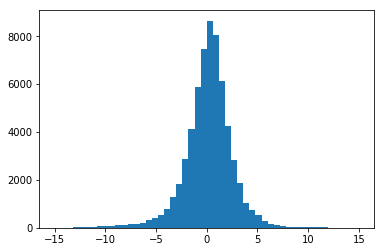

negative: 0.43268794188233767
positive: 0.5673120581176623
count    61668.000000
mean         0.160998
std          2.437505
min        -20.180207
25%         -0.956752
50%          0.322292
75%          1.470707
max         24.303645
Name: consecdist, dtype: float64


In [157]:
temp = df2.loc[df2.age_group==26,'consecdist']
plt.hist(temp, bins=50, range=[-15, 15])
plt.show()
temp.describe()
print('negative: {}'.format(sum(temp<0)/temp.shape[0]))
print('positive: {}'.format(sum(temp>0)/temp.shape[0]))
print(temp.describe())

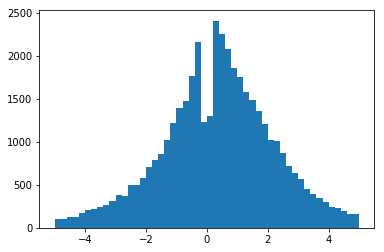

negative: 0.41136389883358354
positive: 0.5886361011664164
count    43295.000000
mean         0.297615
std          2.446590
min        -65.281879
25%         -0.852820
50%          0.411204
75%          1.591762
max         23.258658
Name: consecdist, dtype: float64


In [36]:
temp = df2.loc[df2.age_group==33,'consecdist']
plt.hist(temp, bins=50, range=[-5, 5])
plt.show()
temp.describe()
print('negative: {}'.format(sum(temp<0)/temp.shape[0]))
print('positive: {}'.format(sum(temp>0)/temp.shape[0]))
print(temp.describe())

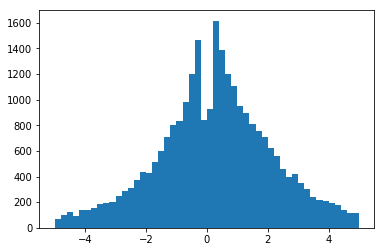

negative: 0.44108632119181695
positive: 0.5589136788081831
count    28058.000000
mean         0.184496
std          2.655028
min        -23.465148
25%         -1.014385
50%          0.293735
75%          1.534835
max         29.607178
Name: consecdist, dtype: float64


In [37]:
temp = df2.loc[df2.age_group==40,'consecdist']
plt.hist(temp, bins=50, range=[-5, 5])
plt.show()
temp.describe()
print('negative: {}'.format(sum(temp<0)/temp.shape[0]))
print('positive: {}'.format(sum(temp>0)/temp.shape[0]))
print(temp.describe())

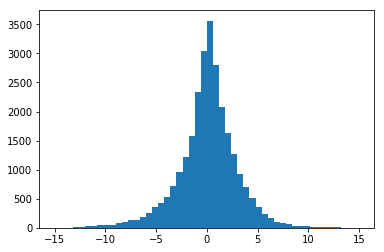

negative: 0.45746412191152536
positive: 0.5425358780884746
count    27036.000000
mean         0.055005
std          3.027239
min        -28.226889
25%         -1.265929
50%          0.227772
75%          1.636117
max         21.698957
Name: consecdist, dtype: float64


In [156]:
temp = df2.loc[df2.age_group==50,'consecdist']
plt.hist(temp, bins=50, range=[-15, 15])
plt.show()
temp.describe()
print('negative: {}'.format(sum(temp<0)/temp.shape[0]))
print('positive: {}'.format(sum(temp>0)/temp.shape[0]))
print(temp.describe())

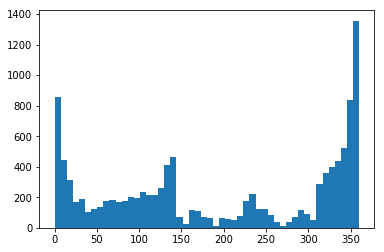

In [8]:
temp = df2.loc[(df2.age_group==18) & (df2.consecdist>0),'degrees']
plt.hist(temp, bins=50)
plt.show()

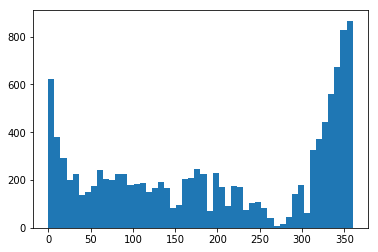

In [9]:
temp = df2.loc[(df2.age_group==18) & (df2.consecdist<0),'degrees']
plt.hist(temp, bins=50)
plt.show()

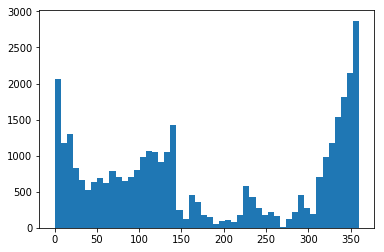

In [7]:
temp = df2.loc[(df2.age_group==26) & (df2.consecdist>0),'degrees']
plt.hist(temp, bins=50)
plt.show()

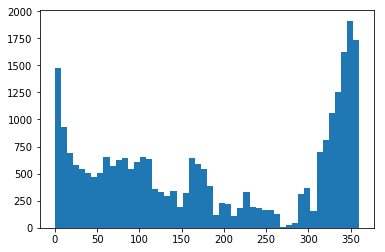

In [10]:
temp = df2.loc[(df2.age_group==26) & (df2.consecdist<0),'degrees']
plt.hist(temp, bins=50)
plt.show()

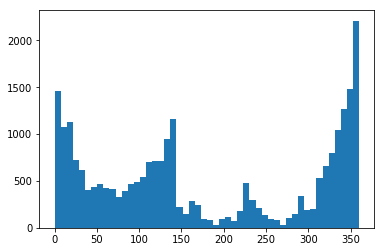

In [6]:
temp = df2.loc[(df2.age_group==33) & (df2.consecdist>0),'degrees']
plt.hist(temp, bins=50)
plt.show()

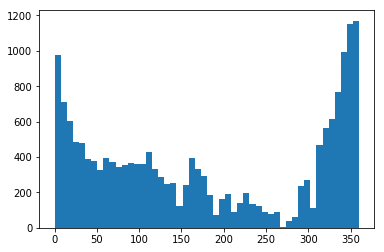

In [11]:
temp = df2.loc[(df2.age_group==33) & (df2.consecdist<0),'degrees']
plt.hist(temp, bins=50)
plt.show()

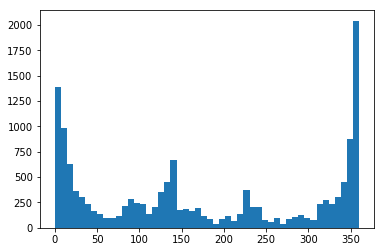

count    14668.000000
mean       177.009402
std        133.926325
min          0.017628
25%         36.059676
50%        144.554302
75%        331.427715
max        359.998254
Name: degrees, dtype: float64


In [12]:
temp = df2.loc[(df2.age_group==50) & (df2.consecdist>0),'degrees']
plt.hist(temp, bins=50)
plt.show()
print(temp.describe())

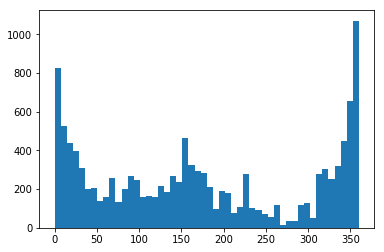

count    12368.000000
mean       174.623067
std        124.499413
min          0.032312
25%         59.730826
50%        158.891708
75%        315.894975
max        359.976682
Name: degrees, dtype: float64


In [14]:
temp = df2.loc[(df2.age_group==50) & (df2.consecdist<0),'degrees']
plt.hist(temp, bins=50)
plt.show()
print(temp.describe())